## 3. Дисбаланс выборки

In [27]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

In [28]:
#Upload datas
water_data = pd.read_csv('data/water_potability.csv')
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))
#Let's show datas
water_data.head()
#Devide the table
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

Рассмотрим влияние дисбаланса на примере датасета о качестве воды. Посмотрим на соотношения классов внутри датасета:

Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64

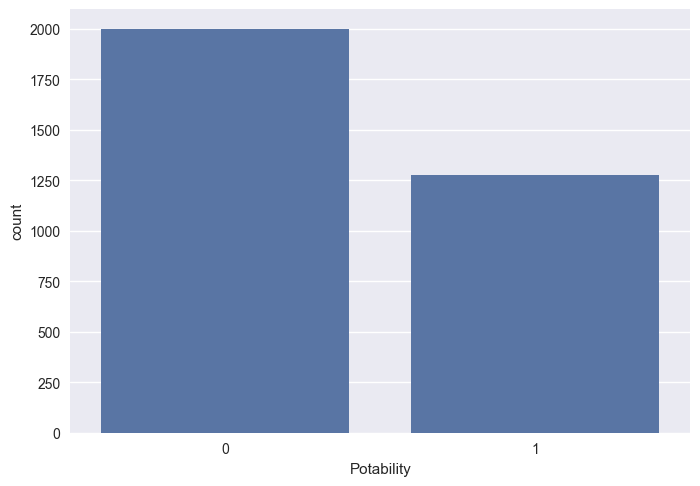

In [29]:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

Итак, около 61 % образцов воды являются непригодными для питья и 39 % являются пригодными. На самом деле это небольшой дисбаланс классов (61/39). В реальных задачах мы можете столкнуться и с куда более неравномерными соотношениями, например 80/20, 90/10 или даже 99/1. Как работать с такими данными, обсудим далее.

#### СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется стратифицированным (stratified). Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами y.

In [30]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
Potability
0    0.609924
1    0.390076
Name: proportion, dtype: float64
Valid:
Potability
0    0.609756
1    0.390244
Name: proportion, dtype: float64


А что насчёт кросс-валидации? Как организовать разбиение по методу k-fold и получить одинаковые соотношения классов?

Для этого вместо KFold используется кросс-валидатор StratifiedKFold. Принцип работы с ним аналогичен, только, в отличие от KFold, StratifiedKFold будет разбивать выборку на части таким образом, чтобы в тренировочных и валидационных фолдах соотношения классов были приблизительно одинаковыми.

Давайте напишем код, который организует стратифицированное k-fold-разбиение на три фолда, и выведем соотношения классов в каждой из выборок:

In [31]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------
Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------
Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------


Видно, что соотношения классов в тренировочной и валидационной выборках в каждом разбиении примерно одинаковы — 61/39.

Так же, как и другие кросс-валидаторы, объект класса StratifiedKFold может быть использован в функции cross_validate()

### ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

Давайте на примере посмотрим, насколько важен выбор метрики в случае дисбаланса выборки.

Разобьём выборку на тренировочную и валидационную в соотношении 80/20, используя стратифицированное разбиение, затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на валидационной выборке с помощью функции classification_report().

In [32]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



Из отчёта о метриках классификации видно, что для валидационной выборки метрика accuracy составляет 0.77, что, в принципе, является довольно хорошим результатом. Однако если мы посмотрим на метрики recall и f1-score для каждого из классов в отдельности, мы увидим, что метрики для класса 0 значительно выше, чем метрики для класса 1.

Мы не смогли бы выявить этот факт, если бы ориентировались только на метрику accuracy. Одной из причин такого результата является дисбаланс классов: образцов непригодной для питья попросту больше, чем пригодных для питья.

Примечание. Поскольку простая accuracy вызывает сомнения в задачах с сильным дисбалансом, были разработаны специальные метрики, основанные на accuracy: это функционал Каппа Коэна (Cohen’s Kappa) и balanced accuracy. Подробнее о них вы можете прочитать здесь.

### ПОСТРОЕНИЕ МОДЕЛИ В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ
ВЗВЕШИВАНИЕ ОБЪЕКТОВ

Посмотрим на реализацию на примере дерева решений:

In [ ]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.63      0.76      0.69       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



ВЫБОР ПОРОГА ВЕРОЯТНОСТИ. PR-КРИВАЯ

PR-кривая (precision-recall curve) — это график зависимости precision от recall при различных значениях порога вероятности.

Для предсказания вероятностей используем функцию cross_val_predict(). Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр method='predict_proba', она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции cross_validate().

In [35]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

Это массив из вероятностей для каждого образца воды. Первое число в строке — вероятность того, что данный образец является непригодным для питья, а второе — вероятность того, что данный образец пригоден для питья.

Нас интересует класс 1 (пригодная для питья вода). Это второй столбец в матрице вероятностей (индекс 1). Выделим этот столбец из матрицы с вероятностями:

In [36]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

Теперь мы можем построить PR-кривую. Для этого воспользуемся функций precision_recall_curve() из модуля metrics библиотеки sklearn. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен она вернёт три массива: значения метрик precision и recall, вычисленных на различных порогах вероятности, и сами пороги вероятности:

In [37]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


Осталось дело за малым. Вычислим значение F1-score при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна. Сделать это можно с помощью функции argmax() из модуля numpy — она возвращает индекс максимального элемента массива.

Best threshold = 0.33, F1-Score = 0.69


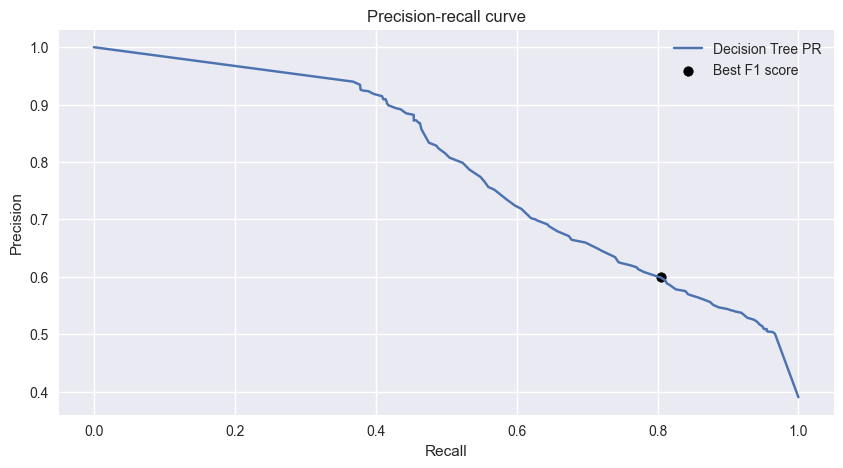

In [38]:
#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [39]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.33
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       400
           1       0.62      0.76      0.68       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



Нам удалось сократить разницу метрик между классами и заставить модель практически одинаково хорошо предсказывать классы питьевой и непитьевой воды.

Примечание. Чтобы вычислить площадь под PR-кривой, используется функция auc() из модуля metrics библиотеки sklearn. В данную функцию нужно передать значения метрик recall и precision при различных порогах вероятности:

In [40]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))
# PR AUC: 0.79

PR AUC: 0.79


СЭМПЛИРОВАНИЕ

Следующий подход работы в условиях дисбаланса классов, который мы рассмотрим, — сэмплирование, а точнее — пересэмплирование (oversampling).

Идея очень проста: если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество.

Алгоритмов сэмплирования, в том числе SMOTE, нет в стандартном пакете sklearn — они содержатся в библиотеке imblearn (imbalanced-learn). Команды для установки приведены далее.

Для пользователей pip:

!pip install imbalanced-learn
Для пользователей anaconda:

!conda install -c conda-forge imbalanced-learn
Все алгоритмы пересэмплирования находятся в модуле over_sampling библиотеки imblearn. Импортируем оттуда алгоритм SMOTE:

In [41]:
from imblearn.over_sampling import SMOTE

Создадим объект класса SMOTE и вызовем у него метод fit_resample(), передав в него обучающую выборку (X_train, y_train). Затем выведем количество наблюдений каждого из классов до и после сэмплирования:

In [42]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
Potability
0    1598
1    1022
Name: count, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
Potability
0    1598
1    1598
Name: count, dtype: int64


Попробуем обучить нашу модель на сгенерированных обучающих данных и сделать предсказание на валидационной выборке (обратите внимание, что с валидационным набором данных мы не производим никаких преобразований), чтобы рассчитать метрики:

In [43]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



Нам удалось поднять метрики для класса 1 на валидационной выборке и снова найти баланс между метриками классов. Однако мы потеряли в метриках для класса 0.

→ Заметьте, что качество всех рассмотренных методов приблизительно одинаковое — они дают примерно идентичное значение метрик. Так получилось для конкретного примера набора данных. Для другого набора данных может получиться совершенно иной результат. Какой из методов сработает лучше, заранее сказать нельзя.